# Molecular property prediction

Install dependencies if necessary (uncomment and run):

In [1]:
# !pip install -r requirements.txt

## 1. Molecular property prediction dataset

We will use BACE dataset from the [MoleculeNet benchmark](https://arxiv.org/abs/1703.00564). Throughout this notebook, we will also make heavy use of [scikit-fingerprints library](https://github.com/scikit-fingerprints/scikit-fingerprints), which is a scikit-learn compatible library built around RDKit.

The task is classifying inhibitors of Beta-Secretase 1 - a protein enzyme playing a significant role in development of Alzheimer’s disease. This is binary graph classification: molecule inhibits protein production or not.

For more information, see: ["Computational Modeling of β-Secretase 1 (BACE-1) Inhibitors Using Ligand Based Approaches" G. Subramanian et al.](https://pubs.acs.org/doi/10.1021/acs.jcim.6b00290)

scikit-fingerprints has its own data loaders for several popular datasets.

In [15]:
from skfp.datasets.moleculenet import load_bace

smiles_list, y = load_bace()

print(f"Example molecule: {smiles_list[0]}")
print(f"Example class: {y[0]}")

Example molecule: O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C
Example class: 1


## 2. Preprocessing

### SMILES -> Mol conversion

We already covered converting SMILES to RDKit `Mol` objects with pure RDKit. Its function works on one string at a time.

scikit-fingerprints allows us to do that for entire dataset with `MolFromSmilesTransformer`. It has the same `.transform()` method as other scikit-learn objects. Note that most classes in scikit-fingerprints do not need `.fit()` call before first usage.

In [16]:
from skfp.preprocessing import MolFromSmilesTransformer

mol_from_smiles = MolFromSmilesTransformer()

mols = mol_from_smiles.transform(smiles_list)

### Scaffold Split

In molecular property prediction, we typically **don't** use random or stratified random split.

In the real-world drug design problems, a trained ML model has to perform well on newly designed molecules. They differ significantly from the ones seen in the training set, e.g. to be patentable. We need a splitting strategy that will force and test **out-of-distribution (OOD) generalization**.

We can group the molecules by the similarity of their core internal structure, called **scaffold**. This effectively splits the data into sets that differ from one another.

It's important to note that there are some slight variations of scaffold split. They differ in definition what is a "core" part of the molecule. Most benchmarks provide explicit splits for datasets, e.g. Open Graph Benchmark ([OGB](https://ogb.stanford.edu/)) provides standardized scaffold splits for MoleculeNet.

In [17]:
from skfp.model_selection import scaffold_train_test_split


mols_train, mols_test, y_train, y_test = scaffold_train_test_split(mols, y, test_size=0.2)

print(f"Train set size: {len(mols_train)}")
print(f"Test set size: {len(mols_test)}")

Train set size: 1210
Test set size: 303


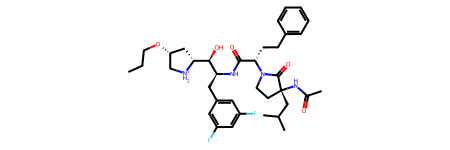

In [18]:
mols_train[0]

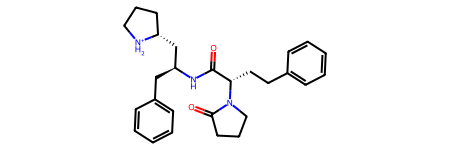

In [19]:
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol


GetScaffoldForMol(mols_train[0])

### Standardize

Molecular standardizer performs basic sanitization and standardization of the molecule object. It will make sure that e.g. certain functional groups or electric charges are represented in a uniform way.

In [20]:
from skfp.preprocessing import MolStandardizer


standardizer = MolStandardizer()

mols_train = standardizer.transform(mols_train)
mols_test = standardizer.transform(mols_test)

## 3. Classification with molecular fingerprints

To transform molecules into feature vectors, we will moleculecular fingerprints. scikit-fingeprints implements a lot of those.

We will start with popular ECFP fingerprint, which is a hashed fingerprint, using circular substructures. This turns our dataset into typical tabular classification problem. Then, we can use any off-the-shelf classifier, like Random Forest.

This is a single-task dataset. In chemistry, we often have **multitask** datasets, where we do many classifications at once. For example, molecule can be toxic in many different ways. `multioutput_auroc_score` in scikit-fingerprints will work in both single-task and multitask cases.

In [21]:
from skfp.fingerprints import ECFPFingerprint


# create fingerprint transformer object
ecfp_fp = ECFPFingerprint()

# transform molecules into feature vectors
X_train_ecfp = ecfp_fp.transform(mols_train)
X_test_ecfp = ecfp_fp.transform(mols_test)

print(f"Fingerprint data shape: {X_train_ecfp.shape}")
print(f"Example vector: {X_train_ecfp[0]}")

Fingerprint data shape: (1210, 2048)
Example vector: [0 1 0 ... 0 0 0]


In [14]:
from sklearn.ensemble import RandomForestClassifier
from skfp.metrics import multioutput_auroc_score


clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf.fit(X_train_ecfp, y_train)

y_pred = clf.predict_proba(X_test_ecfp)[:, 1]
auroc = multioutput_auroc_score(y_test, y_pred)

print(f"ECFP AUROC for Random Forest: {auroc:.2%}")

ECFP AUROC for Random Forest: 41.87%


We can also other models, such as k-nearest-neighbours. Note that we have either binary or count vectors, so we should use an appropriate distance. It is typically Tanimoto distance

Binary Tanimoto distance formula:

$$
\text{dist}(\vec{a}, \vec{b}) = 1 - \frac{|\vec{a} \cap \vec{b}|}{|\vec{a}| + |\vec{b}| - |\vec{a} \cap \vec{b}|}
$$

We can also define Tanimoto distance for count data:

$$
\text{dist}(\vec{a}, \vec{b}) = 1 - \frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\|^2 + \|\vec{b}\|^2 - \vec{a} \cdot \vec{b}}
$$

If you're interested why Tanimoto distance is used, see e.g. ["Why is Tanimoto index an appropriate choice for fingerprint-based similarity calculations?" D. Bajusz et al.](https://doi.org/10.1186/s13321-015-0069-3).

### Exercise 1

Implement kNN classifier, using count ECFP fingerprints and Tanimoto distance. Use [scikit-fingerprints documentation on Tanimoto distance](https://scikit-fingerprints.github.io/scikit-fingerprints/) if necessary.

In [10]:
# import Tanimoto count distance from scikit-fingerprints
...

# create kNN model with appropriate metric
...

# fit, predict
...

# calculate and print AUROC score
...

### Exercise 2

scikit-fingerprints implements over 30 different algorithms. Another popular choice besides ECFP is MACCS, a substructure-based fingerprint.

Implement Random Forest model on binary MACCS fingerprint. Use [scikit-fingerprints documentation](https://scikit-fingerprints.github.io/scikit-fingerprints/) as needed.

In [11]:
# import MACCS fingerprint
...

# create MACCS transformer, calculate fingerprints
...

# train Random Forest, predict
...

# calculate and print AUROC score
...

## 4. Hyperparameter tuning

Molecular fingerprints have many hyperparameters that can be tuned. It's rarely done in papers, but can sometimes greatly improve performance.

Examples are:
- binary vs count variant
- length / number of bits
- ECFP radius

scikit-fingerprints implements `FingerprintEstimatorGridSearch` class for this. It can speed up the tuning of fingerprint and classifier, by avoiding unnecessary recalculations of the fingerprint.

Firstly, we will prepare tuning of the classifier.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = RandomForestClassifier(n_jobs=-1, random_state=0)

clf_param_grid = {"n_estimators": [200, 500, 1000]}

scorer = make_scorer(multioutput_auroc_score, greater_is_better=True)

gridsearch_cv = GridSearchCV(
    estimator=clf,
    param_grid=clf_param_grid,
    scoring=scorer,
    verbose=2,
    cv=5,
    n_jobs=-1,
)

Now, we will set up the tuning of the fingerprint. `FingerprintEstimatorGridSearch` takes the fingeprints, its grid search, and the classifier grid search tuning objects.

In [13]:
from skfp.model_selection import FingerprintEstimatorGridSearch

ecfp_fp = ECFPFingerprint()

fp_grid = {
    "fp_size": [1024, 2048, 4096],
    "radius": [2, 3],
    "count": [False, True],
}

fp_estimator_cv = FingerprintEstimatorGridSearch(
    fingerprint=ecfp_fp,
    fp_param_grid=fp_grid,
    estimator_cv=gridsearch_cv,
    greater_is_better=True,
)

Let's perform the tuning now. We will also check the time, best hyperparameters, and performance after tuning.

In [14]:
from time import time

start = time()
fp_estimator_cv.fit(mols_train, y_train)
end = time()
print(f"scikit-learn tuning time : {end - start:.2f}s")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...................................n_estimators=500; total time=   3.4s
[CV] END ...................................n_estimators=200; total time=   1.5s
[CV] END ...................................n_estimators=500; total time=   3.5s
[CV] END ...................................n_estimators=500; total time=   3.3s
[CV] END ..................................n_estimators=1000; total time=   5.6s
[CV] END ...................................n_estimators=200; total time=   1.5s
[CV] END ..................................n_estimators=1000; total time=   4.4s
[CV] END ...................................n_estimators=200; total time=   1.4s
[CV] END ..................................n_estimators=1000; total time=   4.6s
[CV] END ...................................n_estimators=200; total time=   1.5s


Process LokyProcess-1:
Traceback (most recent call last):
  File "/home/jakub/.cache/pypoetry/virtualenvs/molecular-ml-workshops-E3uaVmXG-py3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 463, in _process_worker
    r = call_item()
        ^^^^^^^^^^^
  File "/home/jakub/.cache/pypoetry/virtualenvs/molecular-ml-workshops-E3uaVmXG-py3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 291, in __call__
    return self.fn(*self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jakub/.cache/pypoetry/virtualenvs/molecular-ml-workshops-E3uaVmXG-py3.11/lib/python3.11/site-packages/joblib/parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jakub/.cache/pypoetry/virtualenvs/molecular-ml-workshops-E3uaVmXG-py3.11/lib/python3.11/site-packages/joblib/parallel.py", line 598, in <listcomp>
    return [func(*args, **kwargs)
            ^^^^^

KeyboardInterrupt: 

In [ ]:
print("Best fingerprint hyperparameters:", fp_estimator_cv.best_fp_params_)

In [ ]:
print("Best model hyperparameters:", fp_estimator_cv.best_estimator_cv_.best_params_)

In [ ]:
y_pred = fp_estimator_cv.predict_proba(X_test)[:, 1]

print(f"ECFP AUROC : {multioutput_auroc_score(y_test, y_pred):.2%}")

## 5. Multioutput prediction

Some molecular datasets focus on multiple tasks at a time. This often results in better classifiers, due to more general knowledge and built-in regularization. Random Forest from scikit-learn, combined with molecular fingerprints, is a natural solution for such problems.

One of such multi-output datasets is SIDER dataset. Tasks are related to adverse drug reactions (ADRs), or drug side effects, to 27 system organ classes of MedDRA classification.

For details, see ["Low Data Drug Discovery with One-Shot Learning" H. Altae-Tran et al.](https://pubs.acs.org/doi/10.1021/acscentsci.6b00367).

### Exercise 3

Perform model training with molecular fingerprints on SIDER dataset.

This consists of steps:
1. Load data
2. Parse as RDKit molecules
3. Scaffold split
4. Computing fingerprints
5. Training Random Forest
6. Evaluation

Code templates have been prepared for you below. Note that they sometimes assume variable names. `extract_pos_proba` function will be useful. Use the previous notebook code and [scikit-fingerprints docs](https://scikit-fingerprints.github.io/scikit-fingerprints/) as necessary.

In [ ]:
# import necessary things
...

# load SIDER dataset: SMILES strings and labels
smiles_list_sider, y = ...

print(f"Example molecule: {smiles_list[0]}")
print(f"Example classes: {y[0]}")
print(f"Number of outputs: {y[0].shape[0]}")

In [ ]:
# import necessary things
...

# parse SMILES as molecules
mol_from_smiles = ...
mols = ...

# scaffold split with 80-20% proportion
mols_train, mols_test, y_train, y_test = ...

# create standardizer and standardize molecules
standardizer = ...

mols_train = ...
mols_test = ...

In [ ]:
# import necessary things
...

# compute fingerprints
ecfp_fp = ...

X_train_ecfp = ...
X_test_ecfp = ...

# train RF classifier
rf_clf = ...

# predict, extract positive class probabilities
...

# calculate AUROC
...


## 6. Pipelines

In ML, we often have multi-step pipelines, with preprocessing, training multiple models, merging their ensembles etc. We can do the same with scikit-fingerprints. Using many different fingerprints often helps.

In [23]:
from skfp.datasets.moleculenet import load_bace
from skfp.model_selection import scaffold_train_test_split

smiles_list, y = load_bace()

smiles_train, smiles_test, y_train, y_test = scaffold_train_test_split(
    smiles_list, y, test_size=0.2
)

In [24]:
ecfp = ECFPFingerprint()
X_train = ecfp.transform(mols_train)
X_test = ecfp.transform(mols_test)

clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]

auroc = multioutput_auroc_score(y_test, y_pred)
print(f"Feature union AUROC for Random Forest: {auroc:.2%}")

Feature union AUROC for Random Forest: 41.98%


In [18]:
from skfp.fingerprints import ECFPFingerprint, TopologicalTorsionFingerprint
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

fps_union = FeatureUnion(
    [
        ("tt_fp", TopologicalTorsionFingerprint()),
        ("ecfp_fp", ECFPFingerprint()),
    ]
)

rf_clf = RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=0)

pipeline = Pipeline(
    [
        ("mol_from_smiles", MolFromSmilesTransformer()),
        ("mol_standardizer", MolStandardizer()),
        ("fps_union", fps_union),
        ("scaler", MinMaxScaler()),
        ("random_forest", rf_clf),
    ]
)
pipeline.fit(smiles_train, y_train)

y_pred = pipeline.predict_proba(smiles_test)[:, 1]

auroc = multioutput_auroc_score(y_test, y_pred)
print(f"Feature union AUROC for Random Forest: {auroc:.2%}")

Feature union AUROC for Random Forest: 40.75%


A major breakthrough in pretraining graph neural networks (GNNs) in chemistry was the paper ["Strategies for Pre-training Graph Neural Networks" W. Hu et al.](https://arxiv.org/abs/1905.12265). Their best AUROC on BACE was 84.5%. Therefore, we managed to outperform a complex, pretrained GNN using simple molecular fingerprints without any pretraining or sophisticated methods.

## Bonus exercise

Peptides are small proteins, with typically up to a few dozen aminoacids. While they are frequently analyzed as text sequences, they are, are all chemistry and biology, molecules built from atoms. Peptide function prediction is an important task in bioinformatics and peptide-based drugs.

One dataset from this domain comes from Long Range Graph Benchmark (LRGB), which proposed a 10-task peptide function prediction dataset with over 15k peptide molecules. For details, see ["Long Range Graph Benchmark" V. Dwivedi et al.](https://arxiv.org/abs/2206.08164). Perform molecule classification on this dataset, using predetermined benchmark splits. It uses AUPRC (Average Precision, AP) as a metric.

1. Load dataset and splits
2. Parse aminoacid sequences as molecules (`MolFromAminoseqTransformer` class)
3. Split molecules and labels
4. Calculate fingerprints, e.g. ECFP, Topological Torsion, EState
5. Use multioutput AUPRC score
6. Compare results with paper

Use [scikit-fingerprints documentation](https://scikit-fingerprints.github.io/scikit-fingerprints/) as necessary.